## PART 1: Load và trực quan vài mẫu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:

TRAIN_DATASET_PATH = '/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
test_image_flair.shape

(240, 240, 155)

In [ ]:
print(test_image_flair.max())

# giá trị pixel max = 1854 -> lạ (cần scale lại)

1854.603271484375


In [ ]:
test_image_flair

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1]))\
.reshape(test_image_flair.shape)

In [ ]:
print(test_image_flair.max())

1.0


In [ ]:
# Làm tương tự với các phương thức còn lại
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [ ]:
## Anhr mask
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
print(np.unique(test_mask))

[0. 1. 2. 4.]


-> Chỉ có các nhãn 0, 1, 2, 4: thiếu nhãn 3

In [ ]:
# Convert nhãn thành số nguyên
test_mask=test_mask.astype(np.uint8)
print(np.unique(test_mask))

[0 1 2 4]


In [ ]:
# gán lại nhãn 4 thành nhãn 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 3]


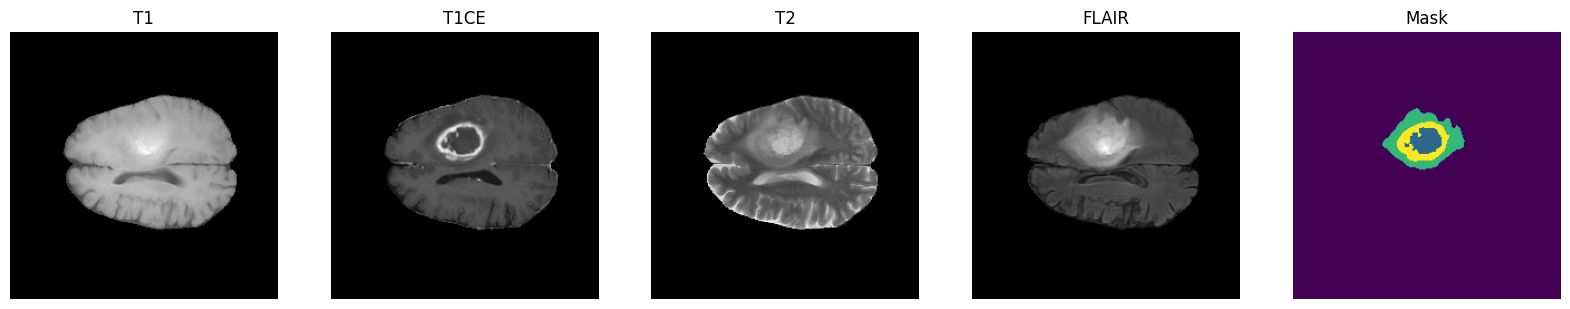

In [ ]:
# random in ra 1 lát cắt
import random
import matplotlib.pyplot as plt

# n_slice = random.randint(0, test_mask.shape[2])
n_slice = 90
# print(n_slice)
fig, axes = plt.subplots(1, 5, figsize=(20, 7))

axes[3].imshow(test_image_flair[:, :, n_slice], cmap='gray')
axes[3].set_title('FLAIR')
axes[3].axis(False)
axes[0].imshow(test_image_t1[:, :, n_slice], cmap='gray')
axes[0].set_title('T1')
axes[0].axis(False)
axes[1].imshow(test_image_t1ce[:, :, n_slice], cmap='gray')
axes[1].set_title('T1CE')
axes[1].axis(False)
axes[2].imshow(test_image_t2[:, :, n_slice], cmap='gray')
axes[2].set_title('T2')
axes[2].axis(False)
axes[4].imshow(test_mask[:, :, n_slice])
axes[4].set_title('Mask')
axes[4].axis(False)

plt.show()



## PART 2: ghép ảnh và chia thành các mảng
Mỗi bệnh nhân có tới 4 kiểu chụp ảnh khác nhau nên cần ghép thành 1 bộ duy nhất

In [ ]:
# Vì Flair, T1CE, và T2 chứa hầu hết các thông tin
# Kết hợp t1ce, t2 và flair thành hình ảnh đa kênh duy nhất

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
combined_x.shape

(240, 240, 155, 3)

In [ ]:
# Vì phần màu đen phía ngoài không chứa thông tin gì -> cắt bỏ đi
combined_x = combined_x[56:184, 56:184, 13:141]
combined_x.shape

(128, 128, 128, 3)

In [ ]:
test_mask = test_mask[56:184, 56:184, 13:141]
test_mask.shape

(128, 128, 128)

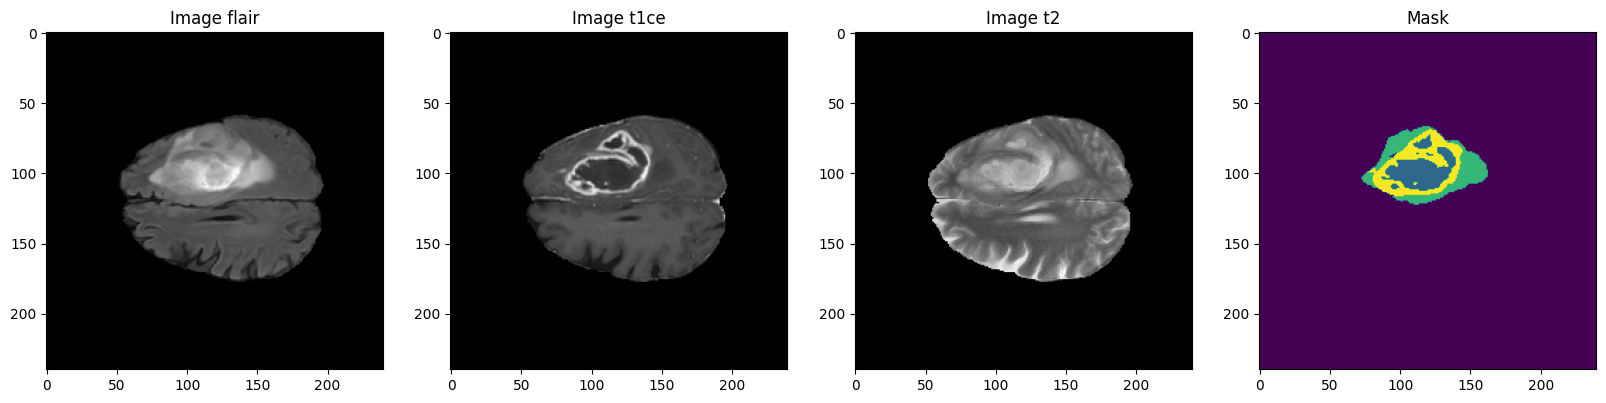

In [ ]:
## Show ra kết quả sau khi đã cắt
# n_slice = random.randint(0, test_mask.shape[2])
# print(n_slice)
n_slice = 100
fig, axes = plt.subplots(1, 4, figsize=(20, 7))
axes[0].imshow(combined_x[:, :, n_slice, 0], cmap='gray')
axes[0].set_title('Image flair')
axes[1].imshow(combined_x[:, :, n_slice, 1], cmap='gray')
axes[1].set_title('Image t1ce')
axes[2].imshow(combined_x[:, :, n_slice, 2], cmap='gray')
axes[2].set_title('Image t2')
axes[3].imshow(test_mask[:, :, n_slice])
axes[3].set_title('Mask')

plt.show()

In [ ]:
combined_x1 = combined_x[56:184, 56:184, 13:141]
combined_x.shape
test_mask1 = test_mask[56:184, 56:184, 13:141]
test_mask1.shape

(128, 128, 128)

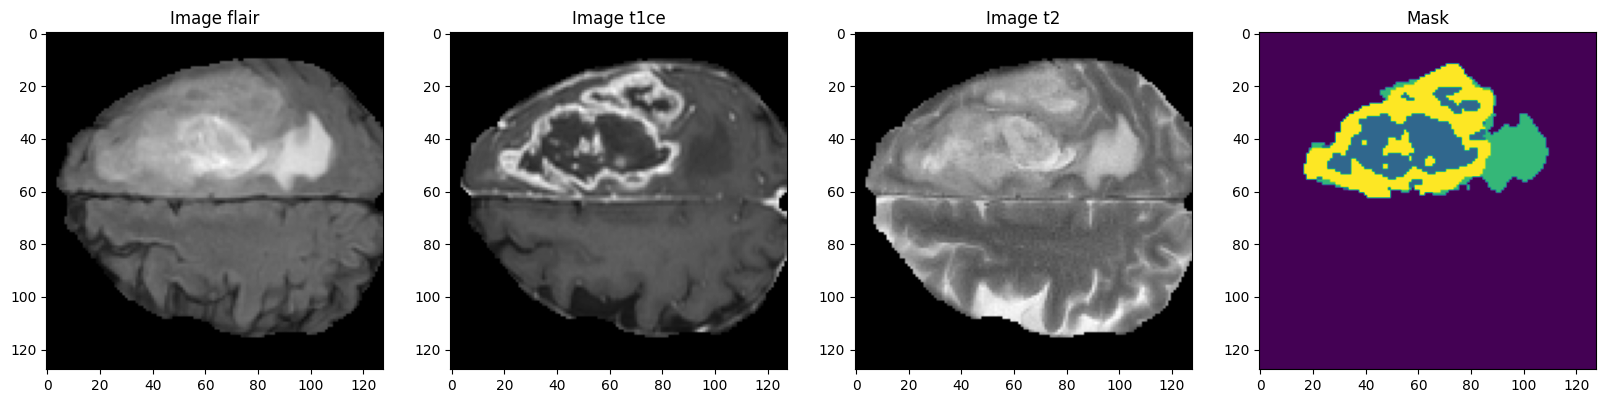

In [ ]:
n_slice = 100
fig, axes = plt.subplots(1, 4, figsize=(20, 7))
axes[0].imshow(combined_x1[:, :, n_slice, 0], cmap='gray')
axes[0].set_title('Image flair')
axes[1].imshow(combined_x1[:, :, n_slice, 1], cmap='gray')
axes[1].set_title('Image t1ce')
axes[2].imshow(combined_x1[:, :, n_slice, 2], cmap='gray')
axes[2].set_title('Image t2')
axes[3].imshow(test_mask1[:, :, n_slice])
axes[3].set_title('Mask')

plt.show()

In [ ]:
# Lưu lại dưới dạng numpy array
np.save('/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project/combined255.npy', combined_x)

In [ ]:
# load lên file numpy array vừa tạo
my_img = np.load('/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project/combined255.npy')

In [ ]:
my_img.shape

(128, 128, 128, 3)

In [ ]:
test_mask = to_categorical(test_mask, num_classes=4)
test_mask.shape

## 4: số nhãn

(128, 128, 128, 4)

# Run here
## Thực hiện cho toàn bộ dữ liệu

In [ ]:
PATH = '/content/drive/MyDrive/Xử lý ảnh Y khoa/Project/Data/MICCAI_BraTS2020_TrainingData'
t2_list = sorted(glob.glob(PATH + '/*/*t2.nii'))
t1ce_list = sorted(glob.glob(PATH + '/*/*t1ce.nii'))
flair_list = sorted(glob.glob(PATH + '/*/*flair.nii'))
mask_list = sorted(glob.glob(PATH + '/*/*seg.nii'))

In [ ]:
len(t2_list)

369

In [ ]:
for img in range(len(t2_list)):
    print("Xử lý ảnh: ", img)

    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3



    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        temp_mask= to_categorical(temp_mask, num_classes=4)

        # Dẫn đến thư mực img: chứa hình
        np.save('/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project/img/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project/mask/mask_'+str(img)+'.npy', temp_mask)

    else:
        print("Bỏ đi")

Xử lý ảnh:  0
Xử lý ảnh:  1
Xử lý ảnh:  2
Xử lý ảnh:  3
Xử lý ảnh:  4
Bỏ đi
Xử lý ảnh:  5
Xử lý ảnh:  6
Xử lý ảnh:  7
Xử lý ảnh:  8
Xử lý ảnh:  9
Xử lý ảnh:  10
Xử lý ảnh:  11
Xử lý ảnh:  12
Xử lý ảnh:  13
Xử lý ảnh:  14
Xử lý ảnh:  15
Xử lý ảnh:  16
Xử lý ảnh:  17
Xử lý ảnh:  18
Xử lý ảnh:  19
Xử lý ảnh:  20
Xử lý ảnh:  21
Xử lý ảnh:  22
Xử lý ảnh:  23
Xử lý ảnh:  24
Xử lý ảnh:  25
Xử lý ảnh:  26
Xử lý ảnh:  27
Bỏ đi
Xử lý ảnh:  28
Xử lý ảnh:  29
Xử lý ảnh:  30
Xử lý ảnh:  31
Xử lý ảnh:  32
Xử lý ảnh:  33
Xử lý ảnh:  34
Xử lý ảnh:  35
Bỏ đi
Xử lý ảnh:  36
Xử lý ảnh:  37
Xử lý ảnh:  38
Xử lý ảnh:  39
Xử lý ảnh:  40
Xử lý ảnh:  41
Xử lý ảnh:  42
Xử lý ảnh:  43
Bỏ đi
Xử lý ảnh:  44
Xử lý ảnh:  45
Xử lý ảnh:  46
Xử lý ảnh:  47
Xử lý ảnh:  48
Xử lý ảnh:  49
Xử lý ảnh:  50
Xử lý ảnh:  51
Xử lý ảnh:  52
Xử lý ảnh:  53
Xử lý ảnh:  54
Xử lý ảnh:  55
Xử lý ảnh:  56
Xử lý ảnh:  57
Xử lý ảnh:  58
Xử lý ảnh:  59
Xử lý ảnh:  60
Bỏ đi
Xử lý ảnh:  61
Xử lý ảnh:  62
Bỏ đi
Xử lý ảnh:  63
Xử lý ảnh:  64

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
# Dẫn đến thư mục Dataset chứa 2 folder img và mask
input_folder = '/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project'

# Dẫn đến 1 thư mục khác ngang hàng với Dataset
output_folder = '/content/drive/MyDrive/Xử lý ảnh Y khoa/DS312_output_project'

In [ ]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values